In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from minisom import MiniSom
from shapely.geometry import Point
import geopandas as gpd
from region_details import get_region_details


In [2]:
# SORT OF USER CONFIGURATION
EFASDIR_HIST="/home/zappa/work_big/EFAS"

# Name Pattern of EFAS data, * reflects different years
watershed='lagen'
#watershed='italy'
tres='day'

#fname_pat=f"{EFASDIR_HIST}/output/6h/efas_italy_*.nc"
fname_pat=f"{EFASDIR_HIST}/output/{tres}/efas_{watershed}_*.nc"
wshed_fname=f"{EFASDIR_HIST}/postpro/{tres}/watersheds/efas_{watershed}_????.nc"
#wshed_fname=f"{EFASDIR_HIST}/postpro/{tres}/watersheds/efas_{watershed}_masked.nc"
fname_dismax=f"{EFASDIR_HIST}/postpro/{tres}/watersheds/basinmax/efas_{watershed}.nc"


# directory of HydroBasins shapefile
shape_dir="/work_big/users/zappa/TRANSLATE/HydroBasins/hybas_lake_eu_lev01-12_v1c/"

# variable name in EFAS file
if tres=='day':
    disname='dis24'
elif tres=='6h':
    disname='dis06'

# starting and last year to be analysed (EFAS historical)
sy=1992
ly=2023

# region details
winfo=get_region_details(watershed)
tlon=winfo['tlon']
tlat=winfo['tlat']
tlabel=winfo['tlabel']
hblevel=winfo['shape_file_level']
bbox=winfo['bounding_box']

# watershed central point
wspoint = Point(tlon, tlat)

# temporary output EFAS timeseries at single point
fname_gp=f"{EFASDIR_HIST}/postpro/{tres}/single_gp/efas_{watershed}_{tlabel}_{tres}.nc"

# FLAGS
plot2d_day=False
ReadExisting=True  # allows faster execution if True. If False, the EFAS data is read from the netcdf files
HazardDef="wmax"   # gridpoint (gp), watershed max (wmax), economic (eco) 

### Read and store water shed data, single grid point

In [3]:
# Read EFAS data for single grid point, and save it to .nc for more rapid access in future executions
def read_and_store_time_series(fname_pat, lat, lon, output_file, ReadExisting):
        
    """
    Read time series data from a specified grid point and store it on disk.
    
    Parameters:
    fname_pat (str or list of str): File path pattern or list of file paths.
    lat_index (int): Index of the latitude grid point.
    lon_index (int): Index of the longitude grid point.
    output_file (str): Output file name to store the time series data (default: 'time_series_data.nc').
    check_existing (bool): Whether to check if the output file already exists (default: True).
    """
    # Check if the output file already exists
    if ReadExisting and os.path.exists(output_file):
        # If the output file exists, read it straight away
        time_series = xr.open_dataset(output_file)
    else:
        # If the output file does not exist, proceed with extracting data from the dataset
        # Open the multi-file dataset
        dataset = xr.open_mfdataset(fname_pat, combine='by_coords')

        # Extract time series data for the specified grid point
        time_series = dataset.sel(lat=lat,lon=lon,method='nearest')

        # Store the extracted time series data on disk
        time_series.to_netcdf(output_file)
    
    return time_series

# xarray
xds_gp = read_and_store_time_series(fname_pat, tlat, tlon, fname_gp, ReadExisting)

# discharge values (convert to numpy array)
ds_gp=xds_gp[disname].values


# Reading watershed

<Axes: >

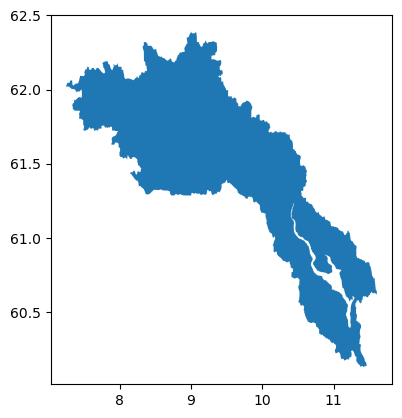

In [4]:
# read watershed shapefiles
def read_watershed_shapefiles(shape_dir, level, wspoint):
    """
    Read watershed shapefiles and extract the shapefile entry that contains a specific point.

    Parameters:
    shape_dir (str): The directory where the shapefiles are located.
    level (str): The level of the shapefiles to read.
    wspoint (Point): The point to analyze.

    Returns:
    GeoDataFrame: A GeoDataFrame containing the shapefile entry that contains the point.
    """
    # Construct the shapefile path
    shapef_path = os.path.join(shape_dir, f"hybas_lake_eu_lev{level}_v1c.shp")

    # Read the shapefile
    shape_gdf = gpd.read_file(shapef_path)

    # Find the shapefile entries that contain the point
    contains_point = shape_gdf['geometry'].contains(wspoint)

    # Extract the shapefile entry that contains the point
    shape_basin_gdf = shape_gdf[contains_point]

    return shape_basin_gdf


def xarray_in_shapefile(xds,varname,latname,lonname,shapef,operation):
    
    # compute average precipitation (ds_emo) for grid points within shape_basin_gdf
    df = xds[varname].to_dataframe()
    lats = df.index.get_level_values(latname)
    lons = df.index.get_level_values(lonname)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(lons,lats),crs='EPSG:4326')

    # created join dataframe between data and shapefile
    gdf_joined = gpd.sjoin(gdf, shapef, predicate='within')

     # Group by time and region, and sum the values
    if operation=='mean':
        results = gdf_joined.groupby(['time', 'index_right'])[varname].mean()
    elif operation=='sum':
        results = gdf_joined.groupby(['time', 'index_right'])[varname].sum()
    elif operation=='max':
        results = gdf_joined.groupby(['time', 'index_right'])[varname].max()

    # Convert the series to a DataFrame and pivot it
    results_df=pd.DataFrame()
    results_df[varname] = results.reset_index().pivot(index='time', columns='index_right', values=varname)
    results_xds=results_df.to_xarray()

    return results_df, results_xds

# read shape file
shape_basin_gdf=read_watershed_shapefiles(shape_dir, hblevel, wspoint)
shape_basin_gdf.plot()


### Compute maximum discharge in watershed (wmax)

In [5]:

# # if maximum discharge exists, read it, otherwise compute it
# if os.path.exists(fname_dismax) and ReadExisting:
#     xds_max=xr.open_dataset(fname_dismax)
# else:
#     # read EFAS data
#     xds=xr.open_mfdataset(wshed_fname,combine='by_coords')
#     #xds['time'] = xds['time'].astype('int64') # convert to int64, or would not write basin-max to netcdf
#     xds_max=xds.max(dim=['lat', 'lon'])

#     # save to file
#     #xds_max.to_netcdf(fname_dismax)

xds=xr.open_mfdataset(wshed_fname,combine='by_coords')
xds_max=xds.max(dim=['lat', 'lon'])
ds_max=xds_max[disname].values

<xarray.Dataset> Size: 327kB
Dimensions:    (time: 11687, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 93kB 1992-01-03 1992-01-04 ... 2024-01-01
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 187kB dask.array<chunksize=(365, 2), meta=np.ndarray>
    dis24      (time) float32 47kB dask.array<chunksize=(365,), meta=np.ndarray>
<xarray.Dataset> Size: 327kB
Dimensions:    (time: 11687, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 93kB 1992-01-03 1992-01-04 ... 2024-01-01
    lon        float64 8B 10.48
    lat        float64 8B 61.11
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 187kB dask.array<chunksize=(365, 2), meta=np.ndarray>
    dis24      (time) float32 47kB dask.array<chunksize=(365,), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  European Centre for 

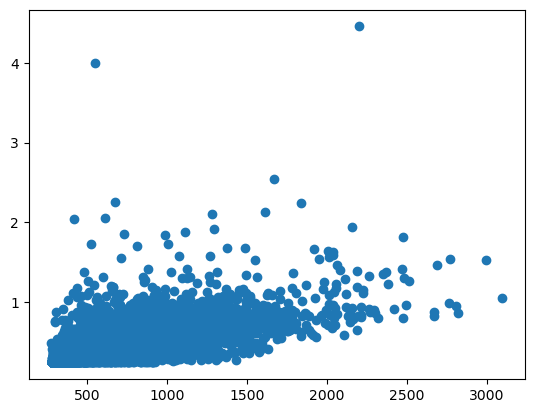

In [6]:
print(xds_max)
print(xds_gp)

plt.scatter(xds_max['dis24'].values, xds_gp['dis24'].values)
plt.show()

# Plot example streamflow map in a given day, with watershed contour

In [7]:
# Plot a map for a day associated with Panaro flooding near Modena
# It would be more efficient if we just read the .nc containing the event (sort by year)
if plot2d_day:   
    #
    dataset2d = xr.open_mfdataset(fname_pat, combine='by_coords')

    # Access variables within the dataset
    time_step = '2013-10-20T18:00:00'  # Example time step
    data2d_day=dataset2d.sel(time=time_step)   
    #variable = dataset2d['dis06'].sel(time=time_step)

    # Extract longitude, latitude, and variable data
    lon, lat, vv = data2d_day['lon'], data2d_day['lat'], data2d_day[disname]

    # Plot the map
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot the variable on the map
    plt.pcolormesh(lon, lat, vv, transform=ccrs.PlateCarree(), cmap='viridis',vmin=0,vmax=800)
    plt.xlim(tlon-2, tlon+2)  # Set longitude range
    plt.ylim(tlat-1, tlat+1)  # Set latitude range

    # Add coastlines, gridlines, and title
    ax.coastlines()
    ax.gridlines()
    plt.title(f'Map for {time_step}')
    plt.colorbar(label='discharge')
    plt.show()


    # Plot a map for a day associated with regional flooding
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.pcolormesh(lon, lat, vv, transform=ccrs.PlateCarree(), cmap='viridis',vmin=0,vmax=5)

    # plot the watershed
    shape_gdf.plot(ax=ax, color='none', edgecolor='red')
    if tlabel=='modena':
        plt.xlim([10, 13])  # Approximate longitude of Italy
        plt.ylim([44, 45.5])  # Approximate latitude of Italy
    plt.show()



# Look at time series of streamflow

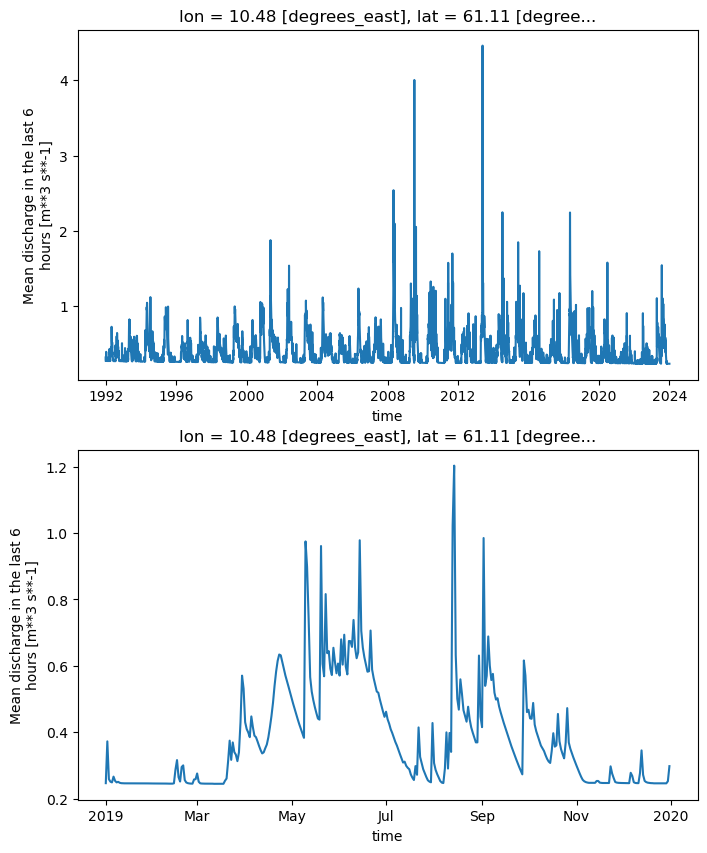

In [8]:

# plot timeseries using xarray 
fig,axs=plt.subplots(2,1,figsize=(8,10))
time_start_plot="1992-01-01"
time_end_plot="2023-12-31"
xds_gp[disname].sel(time=slice(time_start_plot,time_end_plot)).plot(ax=axs[0])
time_start_plot="2019-01-01"
time_end_plot="2019-12-31"
xds_gp[disname].sel(time=slice(time_start_plot,time_end_plot)).plot(ax=axs[1])



### Mean seasonality analyses

/home/zappa/miniforge3/lib/python3.10/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


(0.0, 700.0)

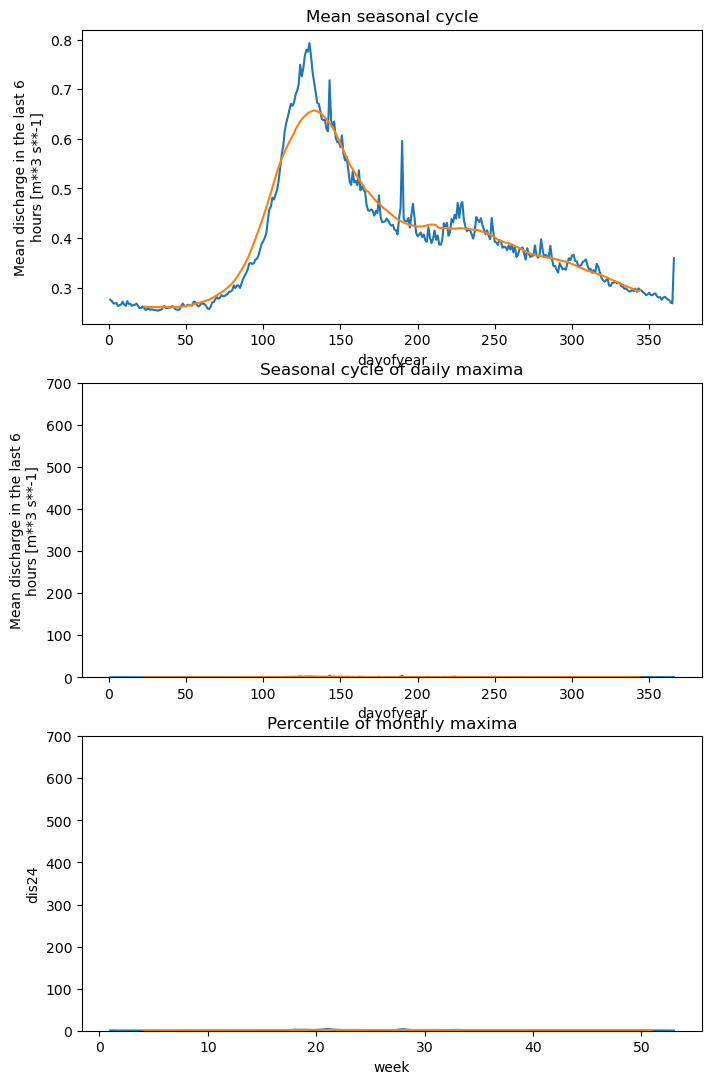

In [9]:
# this is not working, yet
def circular_rolling(da, window_size):
    # Append the start of the DataArray to the end to create a circular buffer
    circular_data = np.concatenate([da, da[:window_size]])

    # Create a new DataArray with the circular buffer
    circular_da = xr.DataArray(circular_data, dims=da.dims, coords=da.coords)

    # Apply the rolling operation
    result = circular_da.rolling({da.dims[0]: window_size}, center=True).mean()

    # Slice off the extra values at the end
    result = result[:len(da)]

    return result


# mean seasonality
daily_means = xds_gp.groupby('time.dayofyear').mean(dim='time')
daily_max = xds_gp.groupby('time.dayofyear').max(dim='time')

percentile_value=99.5 # percentile of extremes values within 1 week window across years
monthly_max = xds_gp.resample(time='1W').max(dim='time').chunk({'time': -1})
monthly_max_p = monthly_max.groupby('time.week').quantile(q=percentile_value / 100, dim='time')
monthly_max_max = monthly_max.groupby('time.month').max(dim='time')

# roolling average
window_size = 45  # Smoothing to highlight mean seasonal cycle
week_size=int(np.round(window_size/7))
smoothed_means = daily_means[disname].rolling(dayofyear=window_size, center=True).mean()
smoothed_max = daily_max[disname].rolling(dayofyear=window_size, center=True).mean()
smoothed_monthly_max = monthly_max_p[disname].rolling(week=week_size, center=True).mean()

# plot stats
plt.figure
fig, axs = plt.subplots(3, 1, figsize=(8, 13))  # 2 rows, 1 column
daily_means[disname].plot(ax=axs[0])
smoothed_means.plot(ax=axs[0])
axs[0].set_title('Mean seasonal cycle')

daily_max[disname].plot(ax=axs[1])
smoothed_max.plot(ax=axs[1])
axs[1].set_title('Seasonal cycle of daily maxima')
axs[1].set_ylim(0, 700)

monthly_max_p[disname].plot(ax=axs[2])
smoothed_monthly_max.plot(ax=axs[2])
axs[2].set_title(f'Percentile of monthly maxima')
axs[2].set_ylim(0, 700)


### Identify extreme events (single grid point)

In [15]:
def find_events(data, prcth, gap=0):
    # data: 1D array of values
    # threshold: threshold value for event detection
    # gap: minimum number of consecutive values below the threshold to consider as a new event

    # define threshold
    threshold=np.percentile(ds_gp, prcth)

    # initialize variables
    events = []
    event_start = None
    event_values = []  # List to store values within each event
    
    # Loop through the data array
    for i, value in enumerate(data):
        if value > threshold:
            # Start of a new event
            if event_start is None:
                event_start = i
            event_values.append(value)
            #print(event_values)
        else:
            # End of an event
            if np.all(data[i:i+gap]<threshold) and event_start is not None:
                print(event_start, i-1, event_values)
                event_start = None  # Reset event start index
                event_values = []  # Reset event_values    

    # Check if an event extends to the end of the array
    if event_start is not None:
        events.append((event_start, len(data)-1), event_values)  # Append the event start and end indices
    
    return events, threshold


In [16]:
# threshold precentile for event definition (across all timesteps)

# minimum number of time steps below threshold between independent events. Otherwise it's the same event
if tres=='day':
    steps_independent_event=1
elif tres=='6h':
    steps_independent_event=3

prcth=98
if HazardDef=='gp':
    print('Identify events by grid point discharge')
    iv_event,dis_threshold=find_events(ds_gp,prcth,steps_independent_event)
elif HazardDef=='wmax':
    print('Identify events by maximum water shed discharge')
    iv_event,dis_threshold=find_events(ds_max,prcth,steps_independent_event)

# Convert events to a pandas DataFrame
df_events = pd.DataFrame(iv_event)
event_length=df_events[2].apply(len)
event_max=df_events[2].apply(max)

# add column with peak intensity
df_events[3]=event_max

plt.figure
plt.plot(event_length,event_max,marker='o', linestyle='None', markersize=5, color='blue')
plt.xlabel(f'length events ({tres}) steps)')
plt.ylabel('event peak (discharge)')
plt.title(f'Events exceeding {prcth}-ptile, {dis_threshold:,.2f} m^3/s')


Identify events by maximum water shed discharge
326.0193
334.80563
343.36746
348.98627
344.24893
337.57654
333.7718
332.01746
329.9999
327.5135
325.04767
330.49423
347.4811
339.79953
348.65997
391.8225
401.97885
403.1322
408.35803
402.57965
387.60178
373.3935
363.53522
355.63843
347.75867
340.71674
335.1466
334.20782
351.56216
374.62576
403.32245
420.01205
420.47107
406.05194
384.6897
364.83932
350.45627
342.68726
340.85693
343.16443
340.23834
336.45135
335.95956
339.7859
342.42236
340.83722
337.16058
332.817
328.607
325.37296
323.05823
321.35403
324.4915
330.78836
336.36166
335.22015
331.68744
332.03976
336.28394
342.1938
342.28973
344.8954
350.58517
347.53888
341.37415
340.2292
343.48706
346.02536
345.9252
354.24664
360.81854
357.1765
351.35837
345.05402
340.21744
337.39066
336.47693
341.884
371.13336
401.18936
419.74963
448.32346
472.6607
469.63855
448.39252
425.86084
405.83673
389.2671
374.72485
362.68558
353.06094
344.6596
337.4745
331.28195
326.79663
324.37854
324.85712
330.7306


TypeError: list.append() takes exactly one argument (2 given)

### Read ERA data

In [ ]:
ERA5dir='/home/zappa/work/ERA5/hourly/'
data_files = {
    ('mean_sea_level_pressure', 'MSL','sfc'),
    ('surface_pressure', 'SP','sfc'),
    ('geopotential','Z','500hPa')
}

years = range(sy, ly+1)

# Loop over each file and variable name
vdata=xr.Dataset()
for variable, variable_name, level_name in data_files:
    if tres=='day':
        erasubdir='day'
        ext=f'day_full_{level_name}_55-55_70_-50_10_55'
        file_paths = f"{ERA5dir}/{variable}/{erasubdir}/ERA5_{variable}_{ext}.nc"
        ds1 = xr.open_dataset(file_paths)
        ds1=ds1.sel(time=slice(str(sy),str(ly)))
    elif tres=='6h':
        erasubdir='6hrs'
        ext=f'6hrs_full_{level_name}_{{year}}_70_-50_10_55'
        file_paths = [f"{ERA5dir}/{variable}/{erasubdir}/ERA5_{variable}_{ext}.nc".format(year=year) for year in years]
        ds1 = xr.open_mfdataset(file_paths,combine='by_coords')

    vdata=vdata.assign(**{variable_name: ds1[variable_name]})
    del ds1

### Read EMO data

/home/zappa/work_big/EMO1/pr/panaro/*.nc
already processed


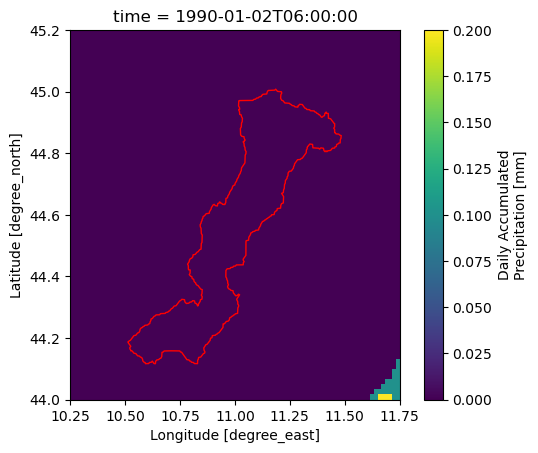

In [ ]:
import glob

## for each file in EMO1 ending in .nc, read it and save it to a new file with the same name in the new directory
EMO1dir='/home/zappa/work_big/EMO1'
file_path_out=f"{EMO1dir}/pr/{watershed}/*.nc"
print(file_path_out)

if glob.glob(file_path_out) and (ReadExisting==True):
    print('already processed')
else:
    for file in glob.glob(f"{EMO1dir}/pr/*.nc"):
        print(file)
        fname=os.path.basename(file)
        ds_emo=xr.open_dataset(file)
        bbox_lon=slice(bbox[1],bbox[3])
        bbox_lat=slice(bbox[2],bbox[0])
        ds_emo=ds_emo.sel(lon=bbox_lon,lat=bbox_lat)
        ds_emo.to_netcdf(f"{EMO1dir}/pr/{watershed}/{fname}")

xds_emo=xr.open_mfdataset(file_path_out,combine='by_coords')

# inspect data 
xds_emo['pr'].isel(time=0).plot()
shape_basin_gdf.plot(ax=plt.gca(), color='none', edgecolor='red')
plt.show()


### Average precipitation in watershed

In [ ]:
# average precip in watershed
df_pr_ws,xds_pr_ws=xarray_in_shapefile(xds_emo,'pr','lat','lon',shape_basin_gdf,'mean')

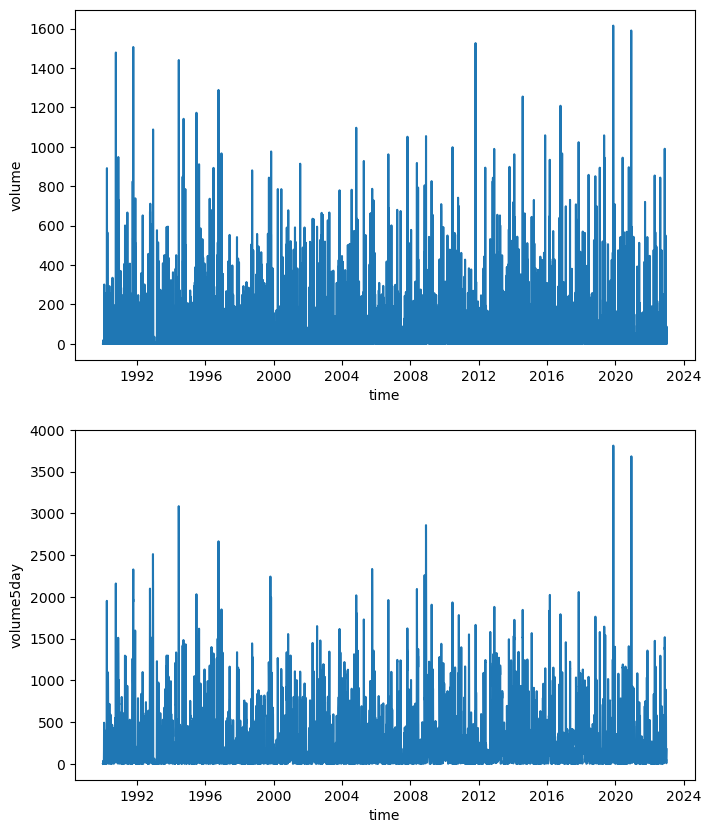

In [ ]:

# convert to totol volume of precip
sec_in_day=24*3600
area_m2=shape_basin_gdf['UP_AREA'].values*10**6    # km2 to m2
xds_pr_ws_ms=xds_pr_ws['pr']/1000/sec_in_day       # convert mm/day to m/s
xds_pr_ws_ms['volume'] = area_m2*xds_pr_ws_ms      # and then to m^3/s

# compute 5-day accumulation
xds_pr_ws_ms['volume5day']=xds_pr_ws_ms['volume'].rolling(time=5).sum()

# inspect the data
fig,axs=plt.subplots(2,1,figsize=(8,10))
xds_pr_ws_ms['volume'].plot(ax=axs[0])
xds_pr_ws_ms['volume5day'].plot(ax=axs[1])

In [ ]:
print(xds_pr_ws_ms['time'])
print(xds_max['time'])

<xarray.DataArray 'time' (time: 12053)> Size: 96kB
array(['1990-01-02T06:00:00.000000000', '1990-01-03T06:00:00.000000000',
       '1990-01-04T06:00:00.000000000', ..., '2022-12-30T06:00:00.000000000',
       '2022-12-31T06:00:00.000000000', '2023-01-01T06:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time        (time) datetime64[ns] 96kB 1990-01-02T06:00:00 ... 2023-01-01...
    volume      (time) float64 96kB 0.0 0.184 0.0 0.0 ... 87.86 1.353 1.098
    volume5day  (time) float64 96kB nan nan nan nan ... 87.24 174.5 174.3 174.7
<xarray.DataArray 'time' (time: 11688)> Size: 94kB
array(['1992-01-02T03:00:00.000000000', '1992-01-03T00:00:00.000000000',
       '1992-01-04T00:00:00.000000000', ..., '2023-12-30T00:00:00.000000000',
       '2023-12-31T00:00:00.000000000', '2024-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 94kB 1992-01-02T03:00:00 ... 2024-01-01
Attributes:
    standard_name:  time
    bounds:  

Text(0.5, 1.0, 'volume precipitation vs peak discharge')

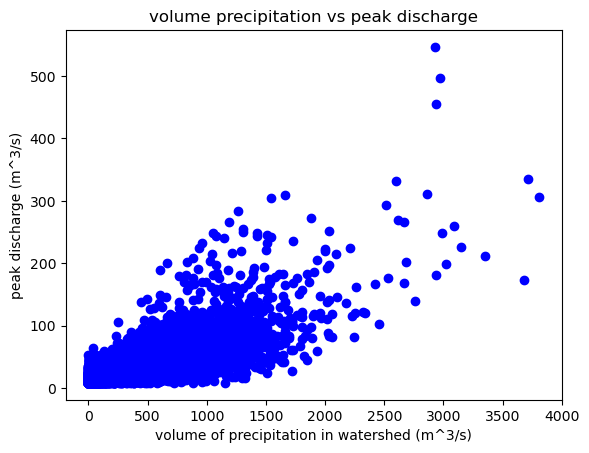

In [ ]:
# scatter of volume precipitation vs peak discharge
time_start_plot="1992-01-05"
time_end_plot="2022-12-31"
time_start_volume="1992-01-04"
time_end_volume="2022-12-30"
plt.figure()
plt.scatter(xds_pr_ws_ms['volume5day'].sel(time=slice(time_start_plot,time_end_plot)),xds_max[disname].sel(time=slice(time_start_plot,time_end_plot)),marker='o',color='blue')
#plt.scatter(xds_pr_ws_ms['volume'].sel(time=slice(time_start_volume,time_end_volume)),xds_max[disname].sel(time=slice(time_start_plot,time_end_plot)),marker='o',color='blue')
plt.xlabel('volume of precipitation in watershed (m^3/s)')
plt.ylabel('peak discharge (m^3/s)')
plt.title('volume precipitation vs peak discharge')

Plot SLP + Z500 for individual events

### Save SLP maps for the events

In [ ]:
print(xds_gp)
print(np.max(df_events_sorted[0].values))

<xarray.Dataset> Size: 327kB
Dimensions:    (time: 11688, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 94kB 1992-01-02T03:00:00 ... 2024-01-01
    lon        float64 8B ...
    lat        float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 187kB ...
    dis24      (time) float32 47kB 3.038 2.972 3.054 3.768 ... 2.433 2.426 2.559
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Mon Jun 17 16:05:43 2024: ncrename -O -v dis06,dis24 output...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...
    NCO:          netCDF Operators version 4.9.7 (Homepage = http://nco.sf.ne...
11628


In [ ]:

# order events based on peak intensity
df_events_sorted=df_events.sort_values(by=3,axis=0,ascending=False)

# extract days in ERA5
#vdata_events=vdata.isel(time=df_events_sorted[0]) # this is ok, fix due to missing leap days in era daily
tref=xds_gp['time'].isel(time=df_events_sorted[0])

# quick fix to bring ERA5 daily means (time 09:00) to the same time as EFAS (time 00:00). This is OK since EFAS reflects trasnport over previous 24 hours
vdata['time'] = vdata['time'] + pd.Timedelta('15H')
vdata_events=vdata.sel(time=tref.values)


/tmp/ipykernel_1939406/2185914311.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  vdata['time'] = vdata['time'] + pd.Timedelta('15H')


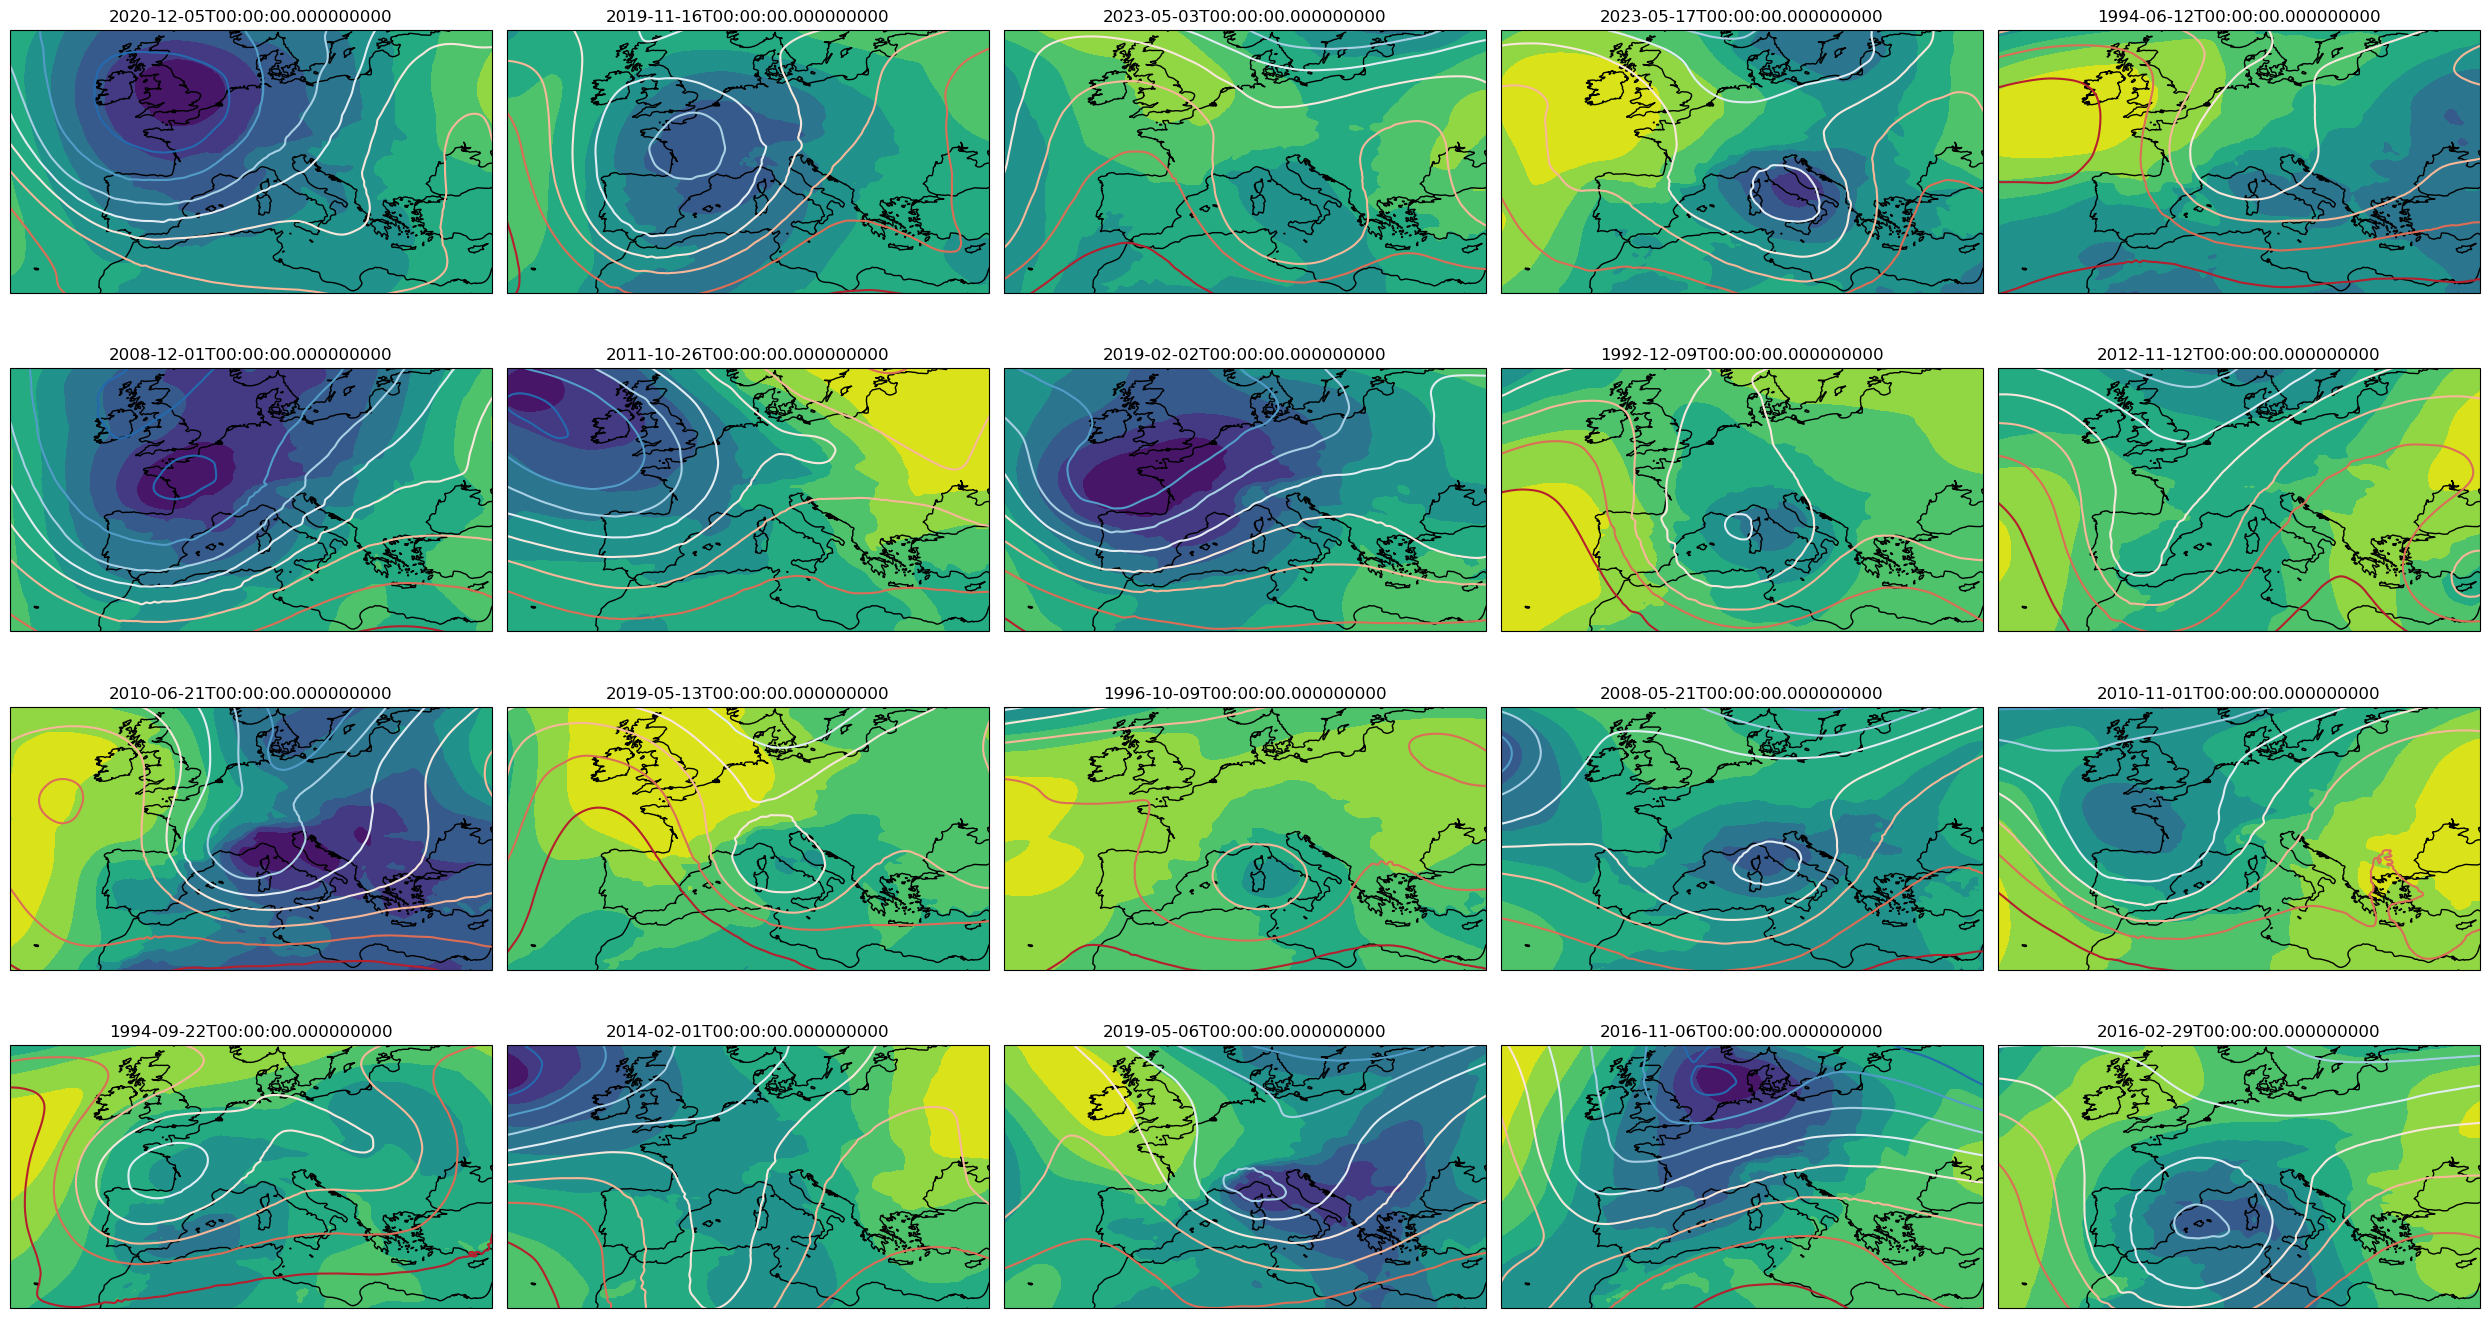

In [ ]:


# plot a subset
max_num_plot=20
#vdata_events_plot=vdata.isel(time=df_events_sorted[0][0:max_num_plot]) # this is ok, fix due to missing leap days in era daily
vdata_events_plot=vdata.sel(time=tref.values[0:max_num_plot])

# Determine the number of time steps
num_times = len(vdata_events_plot.time)

# Calculate the number of rows and columns for the subplot grid
num_rows = int(num_times ** 0.5)
num_cols = (num_times + num_rows - 1) // num_rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through each time step and plot in the corresponding subplot
for i, time in enumerate(vdata_events_plot.time):
    row = i // num_cols
    col = i % num_cols

    # 
    data_at_time = vdata_events_plot.sel(time=time)

    # Set contour levels 
    contour_levels_MSL = np.linspace(data_at_time.MSL.min(), data_at_time.MSL.max(), num=10)
    contour_levels_Z500 = np.linspace(data_at_time.Z.min(), data_at_time.Z.max(), num=10)

    # Plot in the corresponding subplot
    ax = axes[row, col]
    ax.set_title(f'{time.values}')
    
    ax.set_extent([-20, 35, 30, 60], crs=ccrs.PlateCarree())  # Set the desired lat/lon range
    im_MSP = ax.contourf(data_at_time['MSL'].lon, data_at_time['MSL'].lat,
                      data_at_time['MSL'], levels=contour_levels_MSL, cmap='viridis', transform=ccrs.PlateCarree())
    im_Z = ax.contour(data_at_time['Z'].lon, data_at_time['Z'].lat,
                      data_at_time['Z'].sel(plev=50000), levels=contour_levels_Z500, cmap='RdBu_r', transform=ccrs.PlateCarree())

    # Add coastlines using Cartopy
    ax.coastlines()

    # Remove color bar
    cbar = fig.colorbar(im_MSP, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)
    cbar.remove()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()



In [ ]:
def composite_events(vdata, df_events):
    era_events=[]
    for event_start in df_events[0]:
        #print(event_start)
        # Extract data for the event time steps
        era_events_tmp = vdata.isel(time=event_start)
        #print(era_events_tmp.dims)
        # Calculate the average of variable B for the event
        era_events.append(era_events_tmp)
    era_events_concatenated = xr.concat(era_events, dim="event") 
    vdata_clim=vdata.mean(dim='time')
    average_era_events = era_events_concatenated.mean(dim="event")
    average_era_events_anom=average_era_events-vdata_clim

    return average_era_events_anom

## List of variable names you want to extract
#ext='6hrs_full_sfc_{year}_70_-50_10_55'
#data_files = {
#    ('surface_pressure', 'SP')
#}
#years = range(1992, 2024)

# compute composite means... commented: a bit slow become of the anomalies
#comp_mean=composite_events(vdata, df_events)
    

In [ ]:
# print(comp_mean)
# # Plot composite mean anomaly the variable on the map
# fig = plt.figure(figsize=(10, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())

# # Plot the data array
# comp_mean['Z'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# # Add coastlines and gridlines
# ax.coastlines()
# #ax.gridlines()

# # Show the plot
# plt.show()

In [ ]:
from collections import Counter

def train_som(data, num_neurons_x=2, num_neurons_y=3, num_epochs=10000):
    # Create a self-organizing map
    som = MiniSom(num_neurons_x, num_neurons_y, data.shape[1], sigma=0.6, learning_rate=0.25)

    # Train the self-organizing map with the provided data
    som.train_random(data, num_epochs)

    # Prediction
    cluster_index = np.array([som.winner(x) for x in data])
    cluster_index = np.ravel_multi_index(cluster_index.T, (num_neurons_x, num_neurons_y))

    return cluster_index, som

def train_som2(xdata, num_neurons_x=2, num_neurons_y=3, num_epochs=10000):

    # weights
    ww=np.sqrt(np.cos(np.radians(xdata['lat'])))
    xdataw=xdata*ww

    # reshape data to give to minisom
    dd4som_v=xdataw.MSL.values
    dd4som_vr=dd4som_v.reshape(dd4som_v.shape[0],-1)

    # Create a self-organizing map
    som = MiniSom(num_neurons_x, num_neurons_y, dd4som_vr.shape[1], sigma=0.5, learning_rate=0.25)

    # Train the self-organizing map with the provided data
    som.train_random(dd4som_vr, num_epochs)

    # get nodes
    wtt=som.get_weights()

    # Prediction
    cluster_index = np.array([som.winner(x) for x in dd4som_vr])
    cluster_index = np.ravel_multi_index(cluster_index.T, (num_neurons_x, num_neurons_y))

    # reshape before output
    wtt=wtt.reshape(num_neurons_x,num_neurons_y,dd4som_v.shape[1],-1)

    # scale nodes back by area weighting --- to do

    return cluster_index, som, wtt

In [ ]:
# select data for minisom
#dd4som=vdata_events.sel(time=vdata_events.time,lon=slice(-15,30),lat=slice(60,35)).squeeze()
dd4som=vdata_events.sel(lon=slice(-15,30),lat=slice(60,35)).squeeze()
nx=3
ny=2
nn=nx*ny
cli, som1, wtt=train_som2(dd4som,nx,ny)


In [ ]:
def calculate_threshold(som, data, factor=1.0):
    """
    Calculate a distance threshold based on the standard deviation of the distances from each SOM node to the fields associated with it.

    Parameters:
    som (minisom.MiniSom): The trained SOM.
    data (numpy.ndarray): The data used to train the SOM.
    factor (float): The factor to multiply the standard deviation by to calculate the threshold.

    Returns:
    float: The distance threshold.
    """
    # Get the weights of the SOM
    weights = som.get_weights()

    # Calculate the Euclidean distance from each node to each field
    distances = np.linalg.norm(weights[:, :, np.newaxis] - data, axis=-1)

    # Calculate the standard deviation of the distances
    std_dev = np.std(distances)

    # Calculate the threshold as a multiple of the standard deviation
    threshold = factor * std_dev

    return threshold


def get_winner_within_threshold(som, input_vector, threshold):
    """
    Get the winning node for an input vector if the distance is below a given threshold.

    Parameters:
    som (minisom.MiniSom): The trained SOM.
    input_vector (numpy.ndarray): The input vector.
    threshold (float): The distance threshold.

    Returns:
    tuple: The coordinates of the winning node, or None if no node is within the threshold.
    """
    # Get the weights of the SOM
    weights = som.get_weights()

    # Calculate the Euclidean distance from each node to the input vector
    distances = np.linalg.norm(weights - input_vector, axis=-1)

    # Find the coordinates of the node with the minimum distance
    winning_node = np.unravel_index(distances.argmin(), distances.shape)

    # If the minimum distance is below the threshold, return the coordinates of the winning node
    if distances[winning_node] < threshold:
        return winning_node

    # If no node is within the threshold, return None
    return None

30
[0 4 5 4 5 0 3 0 4 2 4 5 5 4 3 4 3 4 2 4 1 3 0 3 3 5 2 1 2 1 1 0 3 1 1 4 0
 3 4 2 1 5 5 3 2 0 0 5 0 3 0 1 5 1 1 2 1 0 5 5 0 4 4 0 1 5 3 2 2 1 4 3 1 2
 4 5 0 0 4 2 1 1 1 4 1 4 5 5 2 4 5 4 2 4 2 4 2 2 0 4 4 3 1 2 3 2 5 3 0 4 2
 0 4 3 0 0 4 0 5 5 1 4 2 5 4 5 4 4 5 0 1 3 0 0 1 1 1 1 3 5 0 0 3 1 4 1 4 5
 2 2 2 2 1 3 2 4 2 1 0 0 5 4 2 5 5 2 1 0 0 4 4 5 5 3]
[0 1 2 3 4 5]


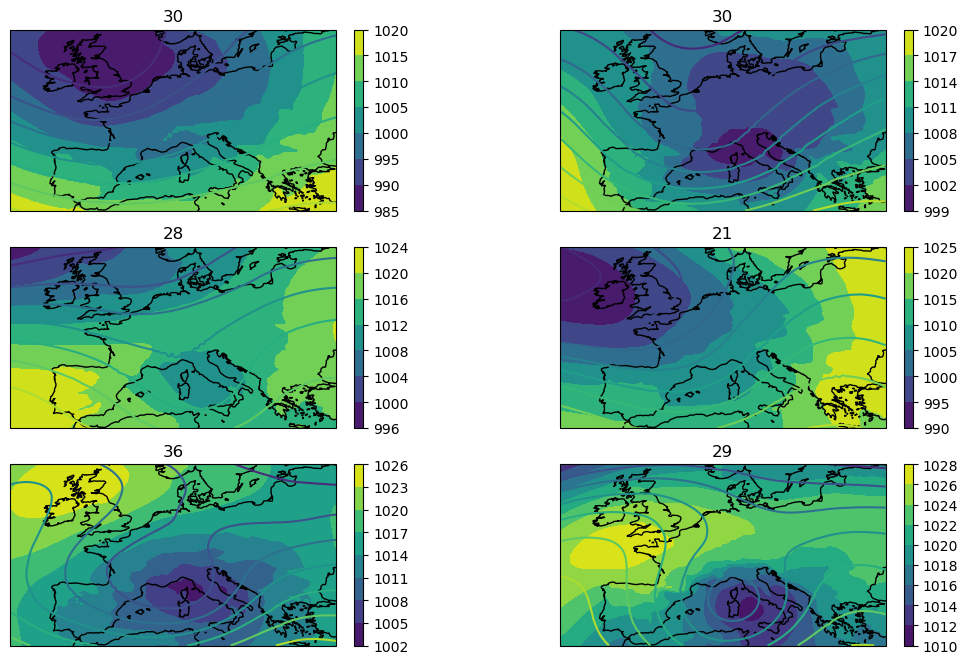

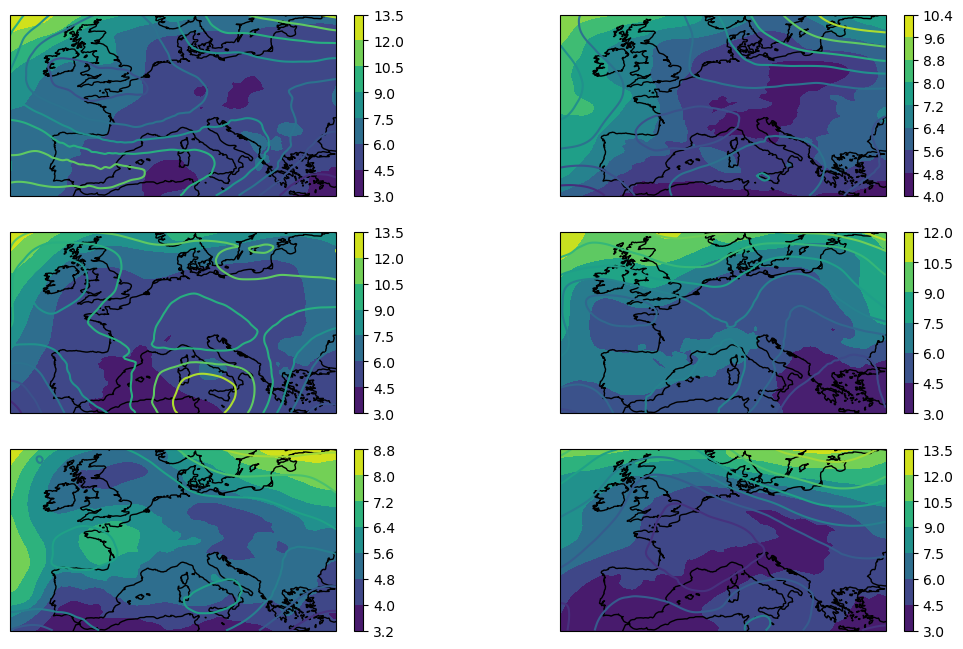

In [ ]:


occurrences=Counter(cli)
print(occurrences[0])

# Initialize an empty array to store mean values

mean_node_MSL = np.zeros((4, dd4som.MSL.values.shape[1], dd4som.MSL.values.shape[2]))
mean_node_Z= np.zeros((4, dd4som.Z.values.shape[1], dd4som.Z.values.shape[2]))

unique=np.unique(cli)
print(cli)
print(unique)

mean_node_MSL = [np.mean(dd4som.MSL.values[cli == i,:,:],axis=0) for i in range(0,nn)]
mean_node_Z = [np.mean(dd4som.Z.values[cli == i,:,:],axis=0) for i in range(0,nn)]
std_node_MSL = [np.std(dd4som.MSL.values[cli == i,:,:],axis=0) for i in range(0,nn)]
std_node_Z = [np.std(dd4som.Z.values[cli == i,:,:],axis=0) for i in range(0,nn)]

# Create a Cartopy projection (PlateCarree for geographic data)
projection = ccrs.PlateCarree()

# Create map of mean node
fig, axs = plt.subplots(nx, ny, figsize=(13, 8), subplot_kw={'projection': projection})

for ax, d1, d2, inode in zip(axs.flat, mean_node_MSL, mean_node_Z, range(0,nn)):
    # Plot the data using pcolormesh
    cax1 = ax.contourf(dd4som['lon'].values, dd4som['lat'].values, d1/100, transform=projection)
    cax2 = ax.contour(dd4som['lon'].values, dd4som['lat'].values, d2, transform=projection)

    # Add coastlines
    ax.coastlines()

    # add number of events
    ax.set_title(f"{occurrences[inode]}")

    # Add a colorbar
    cbar = plt.colorbar(cax1,orientation='vertical', fraction=0.05, pad=0.04)
plt.show()

# Create map of std within each node
fig, axs = plt.subplots(nx, ny, figsize=(13, 8), subplot_kw={'projection': projection})

for ax, d1, d2 in zip(axs.flat, std_node_MSL, std_node_Z):
    # Plot the data using pcolormesh
    cax1 = ax.contourf(dd4som['lon'].values, dd4som['lat'].values, d1/100, transform=projection)
    cax2 = ax.contour(dd4som['lon'].values, dd4som['lat'].values, d2, transform=projection)

    # Add coastlines
    ax.coastlines()


    # Add a colorbar
    cbar = plt.colorbar(cax1, orientation='vertical', fraction=0.05, pad=0.04)
plt.show()


(array([ 6574.,  8035.,  9496., 10957., 12418., 13879., 15340., 16801.,
        18262., 19723., 21184.]),
 [Text(6574.0, 0, '1988'),
  Text(8035.0, 0, '1992'),
  Text(9496.0, 0, '1996'),
  Text(10957.0, 0, '2000'),
  Text(12418.0, 0, '2004'),
  Text(13879.0, 0, '2008'),
  Text(15340.0, 0, '2012'),
  Text(16801.0, 0, '2016'),
  Text(18262.0, 0, '2020'),
  Text(19723.0, 0, '2024'),
  Text(21184.0, 0, '2028')])

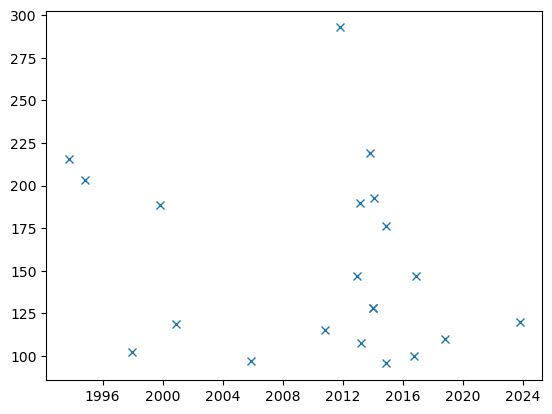

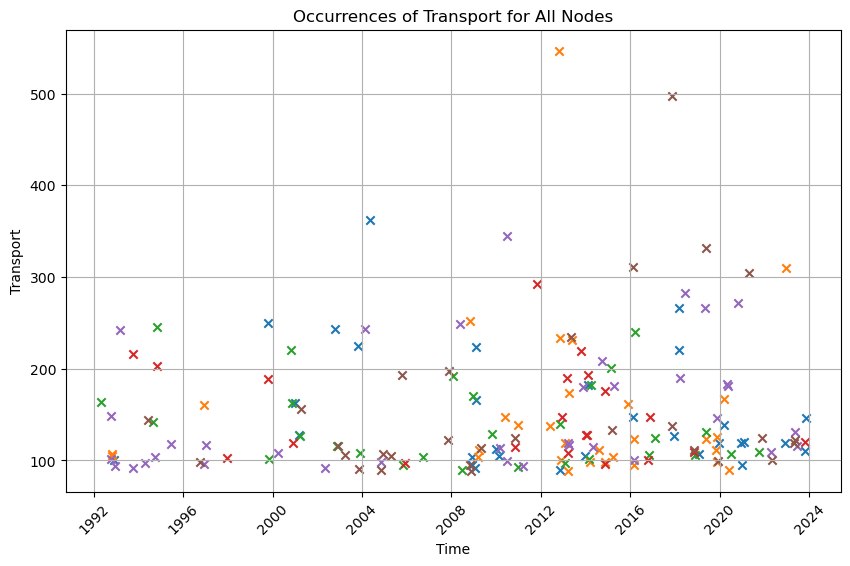

In [ ]:


all_transport_per_class = []
all_time_per_class = []

# Loop over each inode
for inode in range(nn):
    # Filter data for the current inode
    transport_per_class = df_events.loc[cli == inode, [0, 3]]
    time_per_class = dd4som.time[cli == inode]

    # Append the data to the respective lists
    all_transport_per_class.append(transport_per_class)
    all_time_per_class.append(time_per_class)



#plt.plot(all_time_per_class[3].time.values.T)
inode=3
plt.plot(all_time_per_class[inode],all_transport_per_class[inode][3],'x')



# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))

# Iterate over all nodes
for inode in range(len(all_time_per_class)):
    # Extract the time and transport data for the current inode
    time_per_class = all_time_per_class[inode]
    transport_per_class = all_transport_per_class[inode]
    
    # Plot the occurrences for the current inode
    plt.scatter(time_per_class, transport_per_class[3], marker='x', label=f'Node {inode}')

# Add labels and title to the plot
plt.title('Occurrences of Transport for All Nodes')
plt.xlabel('Time')
plt.ylabel('Transport')
plt.grid(True)
plt.xticks(rotation=45)


2) Guardare stagionalità media portata, accadimento eventi
3) Fittare GEV to Annual maxima ... ma con 30 punti ci facciamo poco.... ELENA OK
4) Guardare dipendenza temporale eventi da posizione lungo corso d'acqua ---> massimo trasporto
5) Map tendency of annual maxima (Italy)
6) Composite centered-time evolution of event.
7) Pioggia su bacino idrografico / TCWV ---> OK, calcola tempo scala/lag dominante
8) Dati di stazione (esistono per panaro) 
10) Medie per stagione / o cluster alla grazzini su TCWV
11) Correlazione con fiumi limitrofi

-> distrubuzioni portate per cluster
-> Serie temporale cluster / portata media per cluster / trend portata per cluster 

-> realismo distribuzione portata forecasts
-> validare la stagionlità portata media
-> PDF aggregata per stagione
-> Distribuzione eventi che ti passano soglia / distribuzione massimi annuali

Correlazione spaziale piene spaziali di EFAS / composite o regressione usando o tutti i giorni o eventi di piena. Piene panaro sono associate a piene altri fiumi? Come cambia in funzione del regime?

